In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm.auto import tqdm

In [2]:

dataset_path = '/kaggle/input/nlp-dataset/dataset_2.csv'

dataset = load_dataset("csv", data_files=dataset_path, delimiter=";", header=0)
print(dataset['train'][0]['content'])

On a foggy London night, a policeman makes his rounds, passing I.M. Foreman's junkyard at 76 Totter's Lane. In the junkyard stands an incongruous-looking police box emitting an eerie hum. Another day of classes ends at the Coal Hill School. History teacher Barbara Wright and science teacher Ian Chesterton compare notes on an enigmatic student, Susan Foreman. Her knowledge of history and science surpasses the rest of the class and possibly the teachers. However, she has very curious gaps about present-day culture — for example, she forgets that England has yet to adopt a decimal currency. Barbara has encouraged her to specialise in history, but Susan is resistant to her suggestion about in-home tutoring, saying her grandfather, with whom she lives, doesn't like strangers. Barbara tells Ian she got Susan's address, 76 Totter's Lane, from the school secretary. She went there and found, not a house, but a junkyard. They find Susan so Barbara can lend her a book on the French Revolution. Ia

In [3]:


tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(dataset):
    return tokenizer(dataset["content"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [4]:
tokenized_datasets = tokenized_datasets.remove_columns(["content"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [5]:

torch.cuda.is_available()

True

In [6]:
# split the dataset into train and test sets
train_test = tokenized_datasets["train"].train_test_split(test_size=0.2)


In [7]:
print(len(train_test["test"]))
print(len(train_test["train"]))


463
1852


In [8]:


train_dataloader = DataLoader(train_test["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(train_test["test"], batch_size=8)
     


In [9]:


model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=11)

2025-06-06 14:17:28.473647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749219448.498027     164 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749219448.505179     164 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:


optimizer = AdamW(model.parameters(), lr=5e-5)

In [11]:



num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
     


In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
     

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [14]:


progress_bar = tqdm(range(num_training_steps))




def compute_accuracy(preds, labels):
    return accuracy_score(labels, preds)

def compute_f1(preds, labels):
    return f1_score(labels, preds, average='weighted')

train_loss = []
test_loss = []
acc_test = []
f1_test = []

best_loss = float('inf')
no_improvement_count = 0
early_stopping_patience = 5

model.train()
for epoch in range(num_epochs):
    temp_loss = [] 
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        temp_loss.append(loss.item())
    
    train_loss.append(sum(temp_loss) / len(temp_loss))


    model.eval()
    temp_test_loss = []
    temp_accuracy = []
    temp_f1 = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = outputs.loss
        
        temp_test_loss.append(loss.item())

        temp_acc = compute_accuracy(predictions.cpu().numpy(), batch['labels'].cpu().numpy())
        temp_f1_var = compute_f1(predictions.cpu().numpy(), batch['labels'].cpu().numpy())

        temp_accuracy.append(temp_acc)
        temp_f1.append(temp_f1_var)
    
    avg_test_loss = sum(temp_test_loss) / len(temp_test_loss)
    test_loss.append(avg_test_loss)
    avg_accuracy = sum(temp_accuracy) / len(temp_accuracy) if temp_accuracy else 0
    avg_f1 = sum(temp_f1) / len(temp_f1) if temp_f1 else 0

    acc_test.append(avg_accuracy)
    f1_test.append(avg_f1)


    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        model.save_pretrained("best_model.pth")
        tokenizer.save_pretrained("best_model_tokenizer.pth")

        no_improvement_count = 0
        print(f"New best model saved with loss: {best_loss:.4f} at epoch {epoch + 1}")

    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping triggered after {no_improvement_count} epochs without improvement.")
        break

        

   


     


  0%|          | 0/6960 [00:00<?, ?it/s]

New best model saved with loss: 0.1118 at epoch 1
New best model saved with loss: 0.0965 at epoch 2
New best model saved with loss: 0.0536 at epoch 3
New best model saved with loss: 0.0457 at epoch 4
New best model saved with loss: 0.0433 at epoch 5
New best model saved with loss: 0.0406 at epoch 6
New best model saved with loss: 0.0389 at epoch 7
New best model saved with loss: 0.0379 at epoch 8
New best model saved with loss: 0.0368 at epoch 9
New best model saved with loss: 0.0361 at epoch 10
New best model saved with loss: 0.0357 at epoch 11
New best model saved with loss: 0.0352 at epoch 12
New best model saved with loss: 0.0350 at epoch 13
New best model saved with loss: 0.0346 at epoch 14
New best model saved with loss: 0.0345 at epoch 15
New best model saved with loss: 0.0344 at epoch 16
New best model saved with loss: 0.0343 at epoch 17
New best model saved with loss: 0.0342 at epoch 18
New best model saved with loss: 0.0342 at epoch 19
Early stopping triggered after 5 epochs 

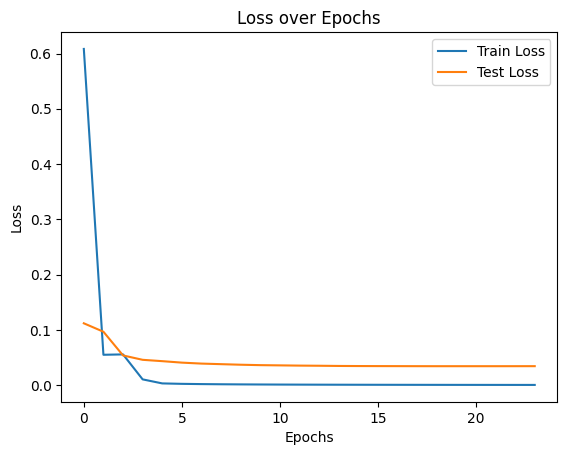

In [15]:
# display the losses on a graph
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

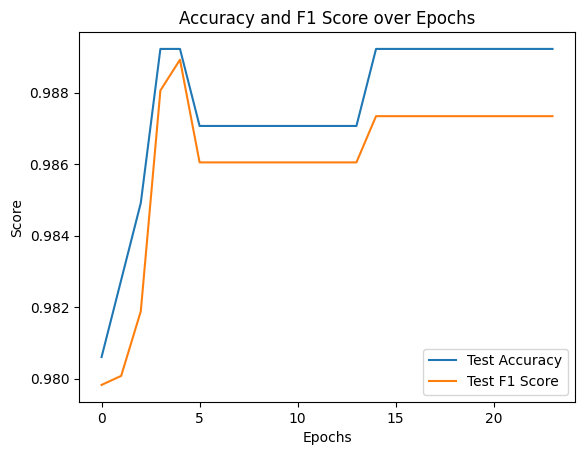

In [16]:
# display accuracy and f1 score
plt.plot(acc_test, label='Test Accuracy')
plt.plot(f1_test, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Accuracy and F1 Score over Epochs')
plt.show()

In [22]:
model.eval()
model.cpu()

dummy_text = "This is a sample input for ONNX export."
inputs = tokenizer(dummy_text, return_tensors="pt")

# Export with only one output
torch.onnx.export(
    model,
    (inputs["input_ids"], inputs["attention_mask"], inputs["token_type_ids"]),
    "bert_base_uncased.onnx",
    input_names=["input_ids", "attention_mask", "token_type_ids"],
    output_names=["last_hidden_state"],  # Just 1 output
    opset_version=14,
    do_constant_folding=True,
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "token_type_ids": {0: "batch_size", 1: "sequence_length"},
        "last_hidden_state": {0: "batch_size", 1: "sequence_length"},
    }
)

print("Exported BERT with only 'last_hidden_state'.")

Exported BERT with only 'last_hidden_state'.
